## Prophet模型预测租车业务收入

### 目录
- 简介
- 数据处理
- 建立模型
- Box-Cox转换

### 简介

        租车业务为主要营收板块，构建一个符合业务特点的预测模型可为决策提供科学依据。经过观察，收入具有明显的周期性（每周变化趋势一致）、趋势性（收入逐年增长），此外，节假日收入会显著升高。鉴于数据的上述特征，尝试使用Facebook开源的Prophet包建立模型并对收入进行预测。

### 1、数据处理

In [1]:
import pandas  as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv(r'D:\jupyter_file\revenue_forecast\20210131_revenue.csv')

In [3]:
#将字符串转换为日期格式、更改列名
df["date"]=df["date"].apply(pd.to_datetime)
df=df.rename(columns={"date":"ds","revenue":"y"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      790 non-null    datetime64[ns]
 1   y       790 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.5 KB


### 2、建立模型

#### 2.1 拟合数据

In [4]:
#输入节日参数
holidays=pd.read_csv(r"D:\jupyter_file\revenue_forecast\holidays.csv",encoding='gbk')
holidays["ds"]=holidays["ds"].apply(pd.to_datetime)
holidays.head()

,holiday,ds,lower_window,upper_window
0,2019年春节,2019-02-04,-3,6
1,2019年清明,2019-04-05,-1,2
2,2019年五一,2019-05-01,-1,4
3,2019年端午,2019-06-07,-1,2
4,2019年中秋,2019-09-13,-1,2


In [5]:
#2020年1月因为疫情，收入下降显著，设置为转折点
m=Prophet(changepoints=["2020-01-24"],holidays=holidays)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 2.2 预测

In [6]:
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

([], [])

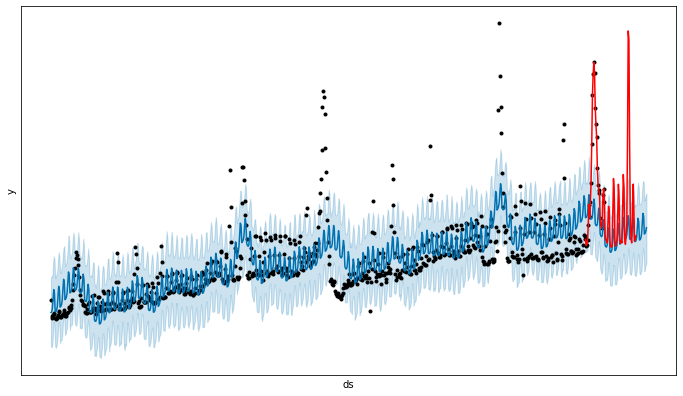

In [7]:
#实际值与预测值比较
df_=pd.read_csv(r"D:\jupyter_file\revenue_forecast\2月迄今.csv",encoding="gbk",parse_dates=["date"],index_col=0)
df_.head
m.plot(forecast)
plt.plot(df_,color="r")
plt.xticks([]) 
plt.yticks([])

预测部分放大

([], [])

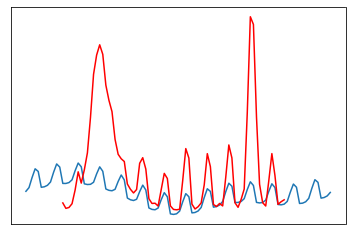

In [8]:
forecast_trunc=forecast.tail(100).set_index("ds")
plt.plot(forecast_trunc["yhat"])
plt.plot(df_,color="r")
plt.xticks([]) 
plt.yticks([])

从对历史数据拟合角度看，模型对非节日数据的拟合效果尚可，但预测效果不好。对于节日，不仅预测值与实际值相差较大，历史数据拟合上也存在此问题。

### 3、模型检验

In [9]:
df_cv = cross_validation(m,initial='365 days',period='90 days',horizon = '180 days')
#df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-03-05 00:00:00 and 2020-09-01 00:00:00


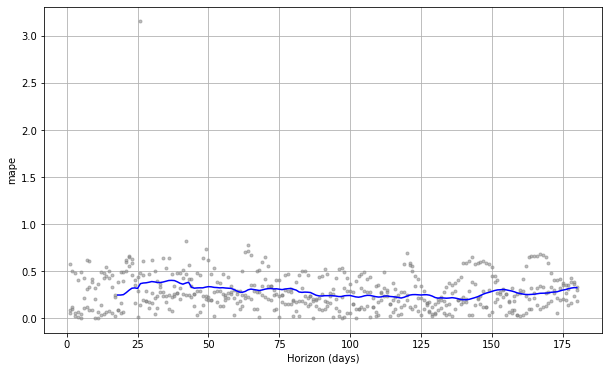

In [10]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

MAPE（绝对平均值误差）在0.25-0.4之间，预测效果不好，还需要优化。

### 4、Box-Cox变换
Box-Cox变换可以明显地改善数据的正态性、对称性和方差齐性等问题。

#### 4.1 数据处理

In [23]:
#Box-Cox的输入是一维数组
df_2=df.copy().set_index("ds")

In [12]:
from scipy import stats
df_2["y"],lambda_prophet =stats.boxcox(df_2["y"])

#恢复成Prophet要求的格式
df_2.reset_index(inplace=True)

#### 4.2 建立模型

In [13]:
m2 = Prophet()
m2.fit(df_2)
future2 = m2.make_future_dataframe(periods=60)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


([], [])

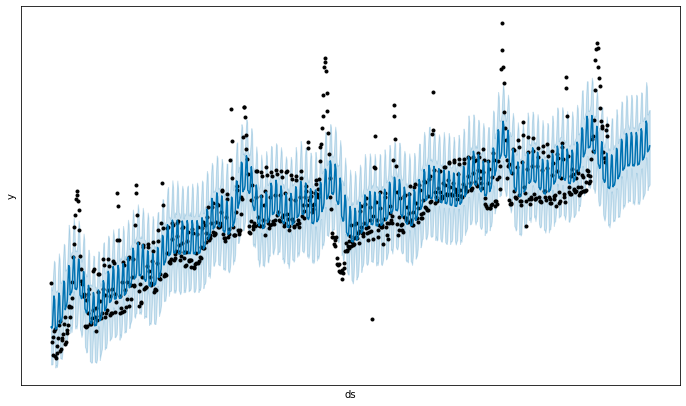

In [14]:
m2.plot(forecast2)
plt.xticks([]) 
plt.yticks([])

#### 4.3 Box-Cox还原

In [15]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [16]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

#### 4.4 模型检验

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-03-05 00:00:00 and 2020-09-01 00:00:00


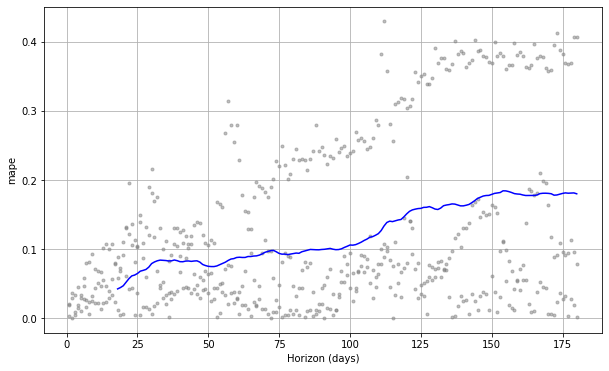

In [17]:
df_cv2 = cross_validation(m2,initial='365 days',period='90 days',horizon = '180 days')
fig2 = plot_cross_validation_metric(df_cv2, metric='mape')

模型预测100天以内数据绝对平均值误差在0.1之内，预测100天以后的数据误差缓慢升高至0.19。对比未进行Box-Cox处理的模型，误差下降明显。

In [18]:
df_f2=forecast2.copy()[["ds","yhat", "yhat_lower", "yhat_upper"]]

In [19]:
df3=pd.merge(df.copy(),df_f2,how="right",on=["ds"])
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 0 to 849
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          850 non-null    datetime64[ns]
 1   y           790 non-null    float64       
 2   yhat        850 non-null    float64       
 3   yhat_lower  850 non-null    float64       
 4   yhat_upper  850 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.8 KB


([], [])

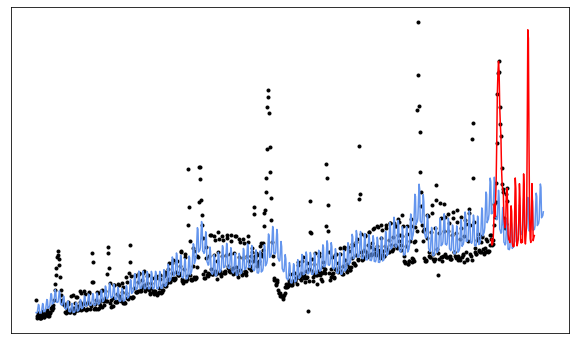

In [20]:
df4=df3.copy().set_index("ds")
plt.rcParams['figure.figsize'] = (10, 6)
plt.scatter(df4.index,df4["y"],marker=".",color="k")
plt.plot(df4["yhat"],color="cornflowerblue")
plt.plot(df_,color="r")
plt.xticks([]) 
plt.yticks([])

截取预测部分作图

([], [])

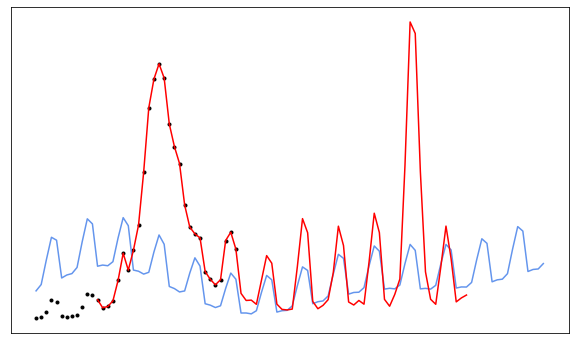

In [21]:
df4_=df4.copy().tail(100)
plt.scatter(df4_.index,df4_["y"],marker=".",color="k")
plt.plot(df4_["yhat"],color="cornflowerblue")
plt.plot(df_,color="r")
plt.xticks([]) 
plt.yticks([])

对比未对数据进行Box-Cox处理的预测结果，模型对非节日数据的预测准确性提高。

#### 相比ARIMA模型，Prophet使用更简单，可解释性更强，抓住了数据的周期性、趋势性特征。为了解决收入不满足正态分布的问题，使用Box-Cox变换处理数据，重新建模后预测准确度提高，但仍不能较好地预测节日收入。

In [22]:
df3.to_csv(r"D:\jupyter_file\收入预测_ARIMA和Prophet\res.csv")